In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import math
import matplotlib.pyplot as plt

from pandas import get_dummies
from sklearn import preprocessing
from sklearn import cross_validation, metrics 
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_auc_score

from sklearn.svm import SVR
from sklearn import ensemble
from sklearn.metrics import mean_squared_error


%matplotlib inline
plt.style.use('ggplot')

In [2]:
from Bio.SeqUtils import ProtParamData  
from Bio.SeqUtils import IsoelectricPoint
from Bio.Seq import Seq
from Bio.Alphabet import IUPAC
from Bio.Data import IUPACData
from Bio.SeqUtils import molecular_weight
from Bio import SeqIO
from Bio.SeqUtils import ProtParam

## Feature engineering 
* Log50000
* chemical structure
* kidera factors
* Phylogenetic tree

In [3]:
"""
logarithming according to articles
"""
def log_meas(current):
    new_meas = 1 - math.log(current, 50000.0)
    if new_meas > 1: new_meas = 1
    if new_meas < 0: new_meas = 0
    return new_meas

In [4]:
"""
analyse_seq adds to DataFrame data with peptide sequences  columnns with chemical attributes of peptide
"""

def analyse_seq(sequences):
    physochem = pd.DataFrame()
    mol_weight = []
    aromaticity = []
    instability_index = []
    isoelectric_point = []
    for i in sequences:
        X = ProtParam.ProteinAnalysis(i)
        mol_weight.append(X.molecular_weight())
        aromaticity.append(X.aromaticity())
        instability_index.append(X.instability_index())
        isoelectric_point.append(X.isoelectric_point())
    physochem["molecular_weight"] = mol_weight
    physochem["aromaticity"] = aromaticity
    physochem["instability_index"] = instability_index
    physochem["isoelectric_point"] = isoelectric_point
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(physochem[["molecular_weight","instability_index", "isoelectric_point"]])
    x_scaled = pd.DataFrame(x_scaled, columns=["molecular_weight","instability_index", "isoelectric_point"])
    physochem["molecular_weight"] = pd.DataFrame(x_scaled["molecular_weight"])
    physochem["instability_index"] = pd.DataFrame(x_scaled["instability_index"])
    physochem["isoelectric_point"] = pd.DataFrame(x_scaled["isoelectric_point"])
    return physochem

In [5]:
"""
to_one_hot function replaces "sequence" row in DataFrame data with OneHotEncoded sequences
"""
def to_one_hot(data, length):
    NMers = data[data["peptide_length"] == length].reset_index(drop=True)
    letters = NMers.sequence.apply(list) 
    #data_1Hot = pd.get_dummies(pd.DataFrame(list(letters)))
    #return pd.concat([NMers.drop(["sequence"], axis = 1), data_1Hot], axis = 1)
    return pd.get_dummies(pd.DataFrame(list(letters)))
    

In [6]:
"""
select_by_allele function returns DataFrame, which consists from data for one mhc by its allele
"""
def select_by_allele(data, allele):
    return data[data.mhc == allele].drop(["mhc"], axis = 1).reset_index(drop = True)

In [7]:
"""
add_kidera_ftr function returns DataFrame with kidera factors on column for a given peptide
"""
def add_kidera_ftr(peptides):
    kidera_peptides = pd.DataFrame()
    for i,fact in enumerate(f): 
        kidera_peptides[fact]=[add_kidera(j)[i] for j in peptides]
        #kidera_selected[fact] = pd.DataFrame(data[fact][indexes]).reset_index(drop=True)
    return kidera_peptides

amino=pd.read_csv("acids.csv", sep=" ", index_col=False)
d = amino.to_dict(orient='list')
f = ['f1','f2','f3','f4','f5','f6','f7','f8','f9','f10']

def add_kidera(pept):
    seq = list(pept)
    dim = len(seq)
    kidera = [0]*10
    for i in range(10):
        kidera[i] = [0]*dim
       
    for k in range(dim):
        for i in range(20):
            if seq[k] == d['amino'][i]:
                for j in range(10):
                    kidera[j][k] = d[f[j]][i]
   
    for i in range(10):
        kidera[i] = sum(kidera[i])/len(kidera[i])
   
    return kidera

## Dataset

In [44]:
Bdata = pd.read_csv("../mhc/bdata.csv")
Bdata.tail()
Bdata.meas = [log_meas(i) for i in Bdata.meas]
peptides9mers = Bdata[Bdata.peptide_length == 9].sequence
sequences = Bdata.sequence

In [10]:
Bdata.meas.describe()

count    179692.000000
mean          0.271944
std           0.282523
min           0.000000
25%           0.084687
50%           0.112837
75%           0.456245
max           1.000000
Name: meas, dtype: float64

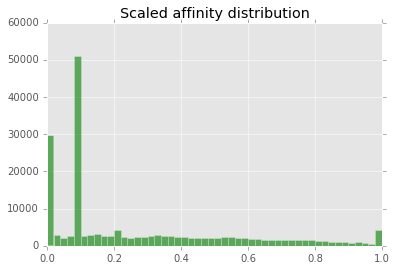

In [11]:
plt.title("Scaled affinity distribution")
hh = plt.hist(Bdata.meas, 50, color = 'green', alpha = 0.6)

## Sequence2Vector
* Word2Vec
* Doc2Vec
* Database of human proteins from uniprot.org
* Peptides from mhc binders

In [41]:
import logging
import os
import sys

import gensim
from gensim.models.doc2vec import TaggedDocument
from gensim.models import word2vec, Doc2Vec
from functools import partial

logging.basicConfig(format='%(levelname)s : %(message)s', level=logging.INFO)
logging.root.level = 20  # ipython messes up logging, restore root

In [51]:
def fill_spaces(seq):
    new_seq = list(seq)
    for i in range(1, len(seq)):
        new_seq[i] = " "+ new_seq[i]
    return ''.join(new_seq)

def seq2vec(model, seq):
    return model[list(seq)].flatten()

def get_proteins_from_fasta(data_path):
    list_of_sequences = []
    for seq_record in SeqIO.parse(data_path, "fasta"):
        list_of_sequences.append((str(seq_record.seq)))
    return pd.Series(list_of_sequences).apply(fill_spaces)

def get_peptides_from_Bdata(sequences):
    return sequences.apply(fill_spaces)

def iterate_uniprot_labeled_ngrams(input_data, n=3):
    """
    Create n-gram sequence generator from the primary structure in
    the FASTA format. 
    :param input_data: str path to the input data
    :param n: int n-gram size
    """
    for seq_record in SeqIO.parse(input_data, "fasta"):
        ngrams = []
        sequence = str(seq_record.seq)
        for it in range(n):
            ngrams.extend(
                [sequence[i + it:i + n + it]
                 for i in range(0, len(sequence) - 1, n)
                 if len(sequence[i + it:i + n + it]) == n])
        yield TaggedDocument(words=ngrams, tags=[seq_record.id])
        


In [49]:
def train_seq2vec(data, epochs=5, min_word_count = 10, num_workers = 4,
                  context = 4, downsampling = 1e-3, w2v_dim = 20):
    
    if(isinstance(data, str)):
        sequences_for_w2v = get_proteins_from_fasta(data)
    else:
        sequences_for_w2v = get_peptides_from_Bdata(data)
    
    print("Training model...")
    w2v_model = word2vec.Word2Vec(sequences_for_w2v, workers=num_workers, size = w2v_dim,
                              min_count = min_word_count, window = context, sample = downsampling)

    print("Done.")

    return w2v_model   


def train_doc2vec(data_path, epochs=15, size=100, window=4, min_count=5, workers=8, ngram_size=3):
    """
    Train the Doc2Vec model on the protein primary structures data in the FASTA format.
    :param data_path: str path to the data
    :param epochs: int
    :param size: int
    :param window: int
    :param min_count: int
    :param workers: int
    :param ngram_size: int
    """
    it = lambda: iterate_uniprot_labeled_ngrams(data_path, n=3)
    model = gensim.models.Doc2Vec(size=size, window=window, min_count=min_count, workers=workers)
    model.build_vocab(it())
    for i in range(epochs):
        model.train(it())
        logging.info("PROGRESS epoch %s from %s", i + 1, epochs)
    return model

"""
if os.path.exists("protein_model.pkl"):
    # If model was already trained then just load it.
    protein_doc2vec = gensim.models.Doc2Vec.load("protein_model.pkl")
else:
    # Else let's train and save it for later reuse.
    protein_doc2vec = train_model("../mhc/uniprot-human.fasta")
    protein_doc2vec.save("protein_model.pkl")
    """



'\nif os.path.exists("protein_model.pkl"):\n    # If model was already trained then just load it.\n    protein_doc2vec = gensim.models.Doc2Vec.load("protein_model.pkl")\nelse:\n    # Else let\'s train and save it for later reuse.\n    protein_doc2vec = train_model("../mhc/uniprot-human.fasta")\n    protein_doc2vec.save("protein_model.pkl")\n    '

In [55]:
if os.path.exists("protein_model.pkl"):
    # If model was already trained then just load it.
    w2v_proteins = gensim.models.Doc2Vec.load("protein_model.pkl")
else:
    # Else let's train and save it for later reuse
    w2v_proteins = train_seq2vec("../mhc/uniprot-human.fasta")
    w2v_proteins.save("protein_model.pkl")
    
if os.path.exists("peptides_model.pkl"):
    # If model was already trained then just load it.
    w2v_peptides = gensim.models.Doc2Vec.load("peptides_model.pkl")
else:
    # Else let's train and save it for later reuse
    w2v_peptides = train_seq2vec(sequences)
    w2v_peptides.save("peptides_model.pkl")
    


## Dataframes with 9mers peptides

#### 1. Sequence embedding
##### 1.1 Proteins from UniProt

In [58]:
seq2vec9mers_proteins = pd.DataFrame(peptides9mers.apply(partial(seq2vec, w2v_proteins))).reset_index(drop=True)
seq2vec9mers_proteins = pd.DataFrame(list(seq2vec9mers_proteins.sequence))
seq2vec9mers_proteins.tail()

,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
129808,-0.070466,-1.132948,-0.496687,0.235803,-0.910053,-0.877142,-0.696909,-0.258628,-0.852915,1.091042,...,0.827864,0.796960,-0.204607,-0.807937,-0.245499,1.427431,-0.394118,-0.642358,0.442655,-0.445520
129809,-0.735324,-0.406569,-0.520339,1.181557,-0.196739,-2.291299,0.563426,-0.266201,-0.018502,0.150823,...,1.017957,0.494816,1.114388,-0.740237,-0.997627,-0.390326,0.331035,-0.029821,1.254128,0.416820
129810,-1.162394,-0.790445,0.000995,0.473923,0.834163,-2.541387,1.149772,2.528838,-0.271030,2.552308,...,0.515076,0.488997,0.409078,-1.909338,-1.296944,0.901100,0.065749,-1.236402,-0.624258,0.489092
129811,0.331753,-1.250065,-0.097219,0.300101,-0.483161,0.953044,1.220211,0.358642,0.217377,-0.038371,...,1.378027,-0.421655,-1.407553,-1.144221,-1.934685,0.695509,0.253446,0.262271,0.211380,-0.235470
129812,-0.769455,-2.589313,0.133901,0.885098,-0.646268,-1.362573,1.128449,1.335465,-0.334080,1.075649,...,0.515076,0.488997,0.409078,-1.909338,-1.296944,0.901100,0.065749,-1.236402,-0.624258,0.489092


##### 1.2 Peptides from mhc binders

In [73]:
seq2vec9mers_peptides = pd.DataFrame(peptides9mers.apply(partial(seq2vec, w2v_peptides))).reset_index(drop=True)
seq2vec9mers_peptides = pd.DataFrame(list(seq2vec9mers_peptides.sequence))
seq2vec9mers_peptides.tail()

,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
129808,-0.147348,-0.447794,-0.182057,0.049279,0.160138,0.013314,-0.665189,-0.181651,-0.598852,0.315057,...,0.457616,0.179948,-0.166193,0.099045,0.121977,0.179392,-0.223191,-0.464856,-0.420709,-0.411114
129809,-0.267257,-0.400613,-0.443055,0.015390,-0.172523,0.058740,-0.616768,-0.387740,-0.237128,0.467072,...,0.937162,-0.063937,-0.355156,0.098337,0.212170,0.342942,-0.209382,-0.099737,-0.295770,-0.413778
129810,-0.002574,-0.131166,-0.524530,0.279908,-0.008974,-0.229033,-0.335929,-0.240438,-0.635068,0.155294,...,0.756489,0.257649,-0.005416,0.007550,0.550952,0.362033,-0.204242,-0.083444,-0.061360,-0.416948
129811,-0.107841,-0.146827,-0.162623,-0.047710,0.267500,0.206269,-0.322246,-0.068581,-0.895151,0.322828,...,0.582383,0.151213,-0.508543,0.553957,0.434713,-0.006307,0.238440,-0.408525,-0.308953,-0.188611
129812,0.137728,-0.532681,-0.132943,0.346430,0.178617,-0.205046,-0.694645,0.190223,-0.605324,0.558594,...,0.756489,0.257649,-0.005416,0.007550,0.550952,0.362033,-0.204242,-0.083444,-0.061360,-0.416948


##### 1.3 Correlation matrix "between" embedding models

In [ ]:
embedding_columns = seq2vec9mers_peptides.columns
correlation_matrix = seq2vec9mers_peptides.apply(lambda embedding_columns: seq2vec9mers_proteins.corrwith(embedding_columns))

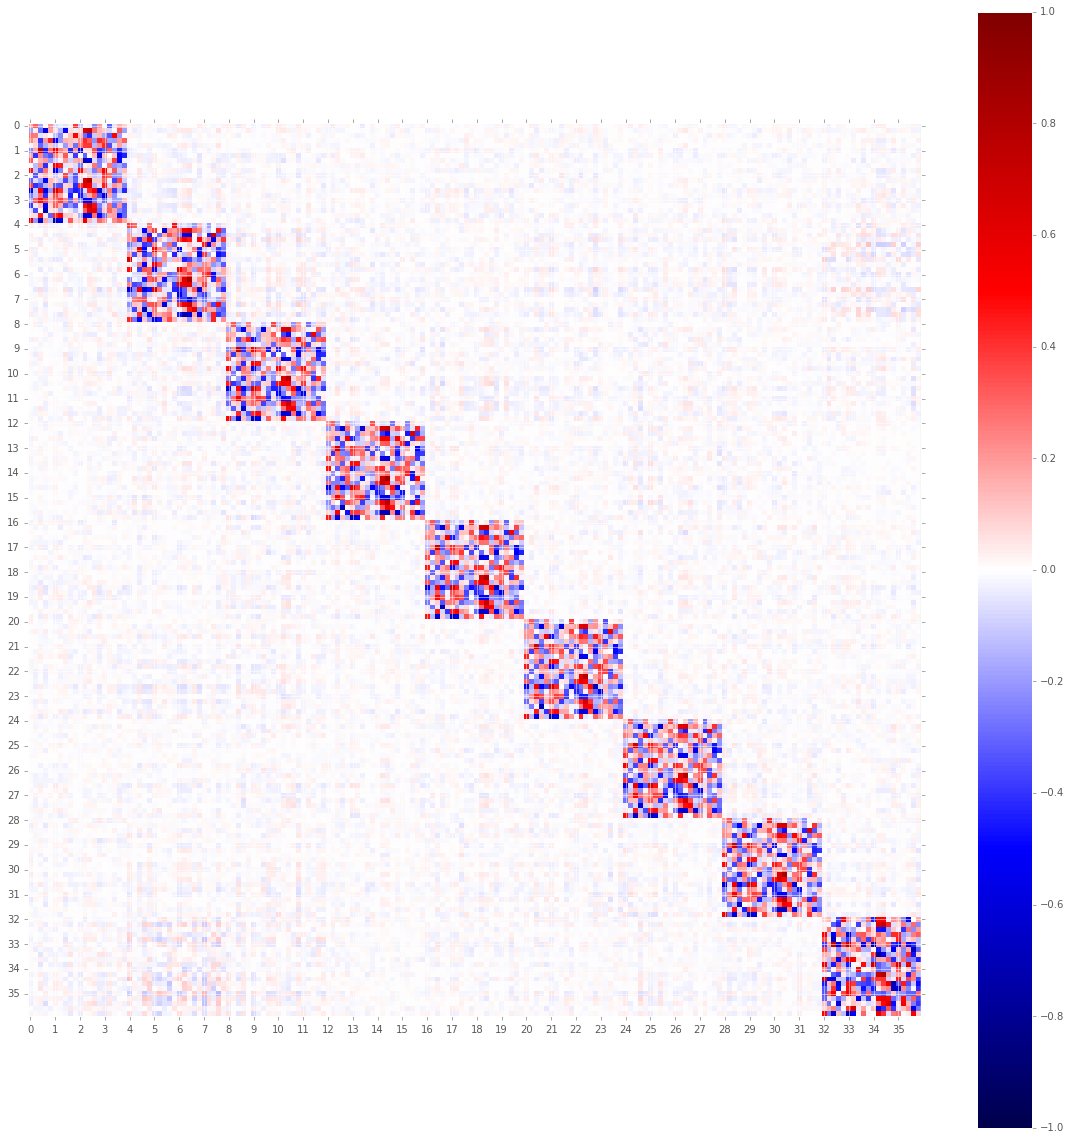

In [84]:
plt.figure(figsize = (20, 20))
plt.imshow(correlation_matrix, cmap='seismic', interpolation='none', vmin=-1, vmax=1, )
plt.colorbar()
x_ = plt.xticks(np.arange(0, 180, 5),correlation_matrix.columns)
y_ = plt.yticks(np.arange(0, 180, 5),correlation_matrix.columns)

#### 2. OneHotEncoded

In [82]:
OneHot9mers = to_one_hot(Bdata, 9)
OneHot9mers.tail()

array([  0,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,
        65,  70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125,
       130, 135, 140, 145, 150, 155, 160, 165, 170, 175])

#### 3. Physochemical properties

In [22]:
PhChemicalData = analyse_seq(peptides9mers)
PhChemicalData.tail()

,molecular_weight,aromaticity,instability_index,isoelectric_point
129808,0.372089,0.000000,0.280008,0.050803
129809,0.323164,0.111111,0.293921,0.064873
129810,0.528654,0.333333,0.353245,0.085869
129811,0.488379,0.111111,0.220120,0.050803
129812,0.533740,0.555556,0.264814,0.246062


#### 4.Kidera factors

In [23]:
KideraData = pd.read_csv("../mhc/Kidera9mers.csv").drop(["Unnamed: 0"], axis=1) #add_kidera_ftr(peptides9mers)
KideraData.tail()


,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10
129808,-0.011111,-0.355556,-0.186667,0.011111,-0.106667,-0.116667,-0.481111,-0.560000,-0.167778,-0.061111
129809,0.172222,-0.478889,-0.176667,-0.304444,0.096667,-0.404444,-0.238889,-0.028889,-0.250000,0.283333
129810,0.367778,0.122222,0.144444,0.002222,-0.051111,-0.146667,-0.062222,0.642222,0.040000,-0.567778
129811,-0.387778,-0.070000,-0.372222,0.003333,0.041111,0.073333,-0.040000,0.148889,-0.108889,0.062222
129812,-0.450000,0.132222,0.138889,-0.887778,-0.113333,-0.695556,0.007778,0.648889,0.823333,-0.368889


#### 5.BLOSUM scoring matrix

In [24]:
blosum_matrix = pd.read_csv("../mhc/blosum.csv").drop(["x"], axis = 1)

def make_blosum(sequences):
    result = pd.DataFrame()
    for cur_seq in sequences:
        encoded = []
        for i, j in enumerate(list(cur_seq)):
            encoded.append(blosum_matrix[j][i])
        result = result.append(pd.Series(encoded), ignore_index = True)
    return result
        
blosum = make_blosum(peptides9mers)

In [25]:
columns = []
for i in blosum_matrix.columns:
    current = [j+str(i) for i, j in enumerate(10*i)]
    columns.append(current)

## Training XGboost

In [26]:
def affinity_to_classes(affinity):
    return pd.Series([round(10*i, 0) for i in affinity])

def affinity_to_binary(affinity):
    return pd.Series(map(lambda x: 1 if x >= 0.5 else 0, affinity))

In [27]:
def xgb_grid_search(data, target):
    
    # split
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(data, target, test_size=0.25, random_state=442)
    
    # train
    
    gbm_params = {
        'min_child_weight': [4, 7], 
        'gamma':[i/10.0 for i in range(0,5)]
    }
    
    print("GridSeachCV proceeding...")
    gbm = GridSearchCV(xgb.XGBClassifier(objective='binary:logistic', max_depth = 7, max_delta_step = 5, learning_rate = 0.15, scale_pos_weight = 2), gbm_params, n_jobs=2, cv=5, verbose=10)
    gbm.fit(X_train, y_train)
    print("Done.")
    
    print(101*"="+ "\nBEST PARAMETERS: ", gbm.best_params_, "\n"+101*"="+"\n")
    predictions = gbm.predict(X_test)
    
    print("==================\nACCURACY : %.4g\n==================" % metrics.roc_auc_score(y_test, predictions))
    

In [28]:
affinity = Bdata[Bdata.peptide_length == 9].meas.reset_index(drop=True)
affinity_classes = affinity_to_classes(affinity)
affinity_binary = affinity_to_binary(affinity)

In [29]:
#xgb_grid_search(OneHot9mers, affinity_binary)

In [30]:
def xgb_regression(data, target):
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(data, target, test_size=0.25, random_state=442)
    
    
    """dtrain = xgb.DMatrix(X_train, y_train)
    dtest = xgb.DMatrix(X_test, y_test)
    bst = xgb.train(param, dtrain, num_round)
    preds = bst.predict(dtest)"""
    
    gbm_params = {
        'learning_rate':[0.03, 0.1, 0.2],
        'n_estimators':[150, 250, 350],
        'max_depth':[3, 5, 7],
        'min_child_weight': [2, 4, 6]        
    }
    
    print("GridSeachCV proceeding...")
    gbm = GridSearchCV(xgb.XGBRegressor(objective='reg:linear', scale_pos_weight = 3), gbm_params, n_jobs=2, cv=5, verbose=10)
    gbm.fit(X_train, y_train)
    print("Done.")
    
    print(101*"="+ "\nBEST PARAMETERS: ", gbm.best_params_, "\n"+101*"="+"\n")
    predictions = gbm.predict(X_test)
    
    print("==================\nMSE : %.4g\n==================" % metrics.mean_squared_error(y_test, predictions))
    
    

Best parameters:  {'learning_rate': 0.2, 'max_delta_step': 5, 'n_estimators': 250, 'max_depth': 7} 
Accuracy: 0.817

In [32]:
data_many_features = pd.concat([PhChemicalData, OneHot9mers, seq2vec9mers], axis=1)
dataframes = [PhChemicalData, OneHot9mers, seq2vec9mers, data_many_features]

NameError: name 'seq2vec9mers' is not defined

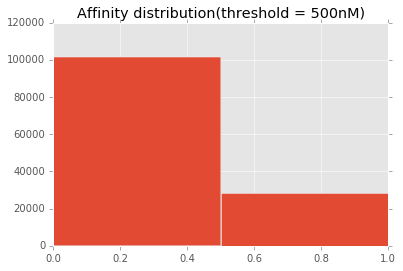

In [33]:
plt.title("Affinity distribution(threshold = 500nM)")
afd = affinity_binary.hist(bins=2)

In [34]:
#xgb_regression(data_many_features, affinity)

In [35]:
def SVR_res(data, target):
    
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(data, target, test_size=0.25, random_state=442)
    """k=['rbf', 'linear','poly','sigmoid','precomputed']
    c= [1e-3, 1e0, 1e1, 1e2, 1e3]
    g=np.arange(1e-4,1e-2,0.0001)
    g=g.tolist()
    param_grid1=dict(kernel=k, C=c, gamma=g)  
    grid = GridSearchCV(SVR(), cv=5,param_grid=param_grid1,)
    grid.fit(train_x, train_y)   
    params = list(grid.best_params_.values())
    TunedSVR = SVR(kernel=params[0], C=params[1], gamma=params[2])
    TunedSVR.fit(train_x, train_y)"""
    TunedSVR = SVR(kernel='rbf', C=1, gamma=0.10000001)
    TunedSVR.fit(X_train, y_train)
    editedPredict = TunedSVR.predict(X_test)
    editedPredict = editedPredict.clip(min=0)
    editedPredict = editedPredict.clip(max=1)
    print("SVR MSE:", mean_squared_error(y_test, editedPredict))
    """print("netmhc MSE:", mse_netmhc)
    print("netmhcpan MSE:", mse_netmhcpan)
    print("smmpmbec_cpp MSE:", mse_smmpmbec_cpp)"""
    plt.plot(editedPredict, test_y, 'ro')

In [36]:
#SVR_res(data_many_features, affinity)

In [37]:
def gbm_regression(data, target):
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(data, target, test_size=0.25, random_state=442)
    
    params = {'n_estimators': 350, 'max_depth': 7, 'min_samples_split': 1,
          'learning_rate': 0.1, 'loss': 'huber'}
    clf = ensemble.GradientBoostingRegressor(**params)
    clf.fit(X_train, y_train)
    mse = mean_squared_error(y_test, clf.predict(X_test))
    print("MSE: %.4f" % mse)

In [ ]:
#gbm_regression(OneHot9mers, affinity)

In [65]:
import numpy.random as rand

In [71]:
df1 = pd.DataFrame(rand.rand(100000, 20))
df2 = pd.DataFrame(rand.rand(100000, 20))
c1 = df1.corrwith(df2)
s = df1.columns
df3 = df1.apply(lambda s: df2.corrwith(s))

In [85]:
np.arange(0, 180, 5)

array([  0,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,
        65,  70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125,
       130, 135, 140, 145, 150, 155, 160, 165, 170, 175])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.000214,0.000737,-0.003726,-0.001591,0.004085,-0.002988,-0.006989,-0.000707,-0.000417,-0.000637,-0.002801,0.003905,-0.000758,-0.000740,-0.002526,-0.000007,-0.000497,0.003784,0.000436,-0.000783
1,0.002206,-0.000326,0.000670,0.001461,-0.001641,-0.004188,-0.005315,-0.002095,-0.001721,0.005352,0.001863,0.000180,-0.000340,0.002941,-0.001477,-0.005406,-0.004372,0.001629,-0.001831,0.003199
2,0.000948,-0.003444,-0.002490,-0.001458,0.002320,0.000046,0.000004,-0.001049,-0.001120,0.002335,-0.005997,-0.003498,0.002495,0.000278,-0.003079,-0.001267,0.003149,0.006148,-0.006107,-0.002746
3,0.000453,-0.001283,0.007460,0.007922,-0.007655,0.002303,0.002706,0.003066,0.002358,-0.004630,0.000564,0.000464,-0.002427,-0.006522,-0.001063,0.003568,-0.003497,0.003925,-0.007151,-0.002544
4,-0.000980,-0.001724,0.001046,-0.001887,0.000806,0.002725,-0.002180,-0.000481,0.000171,-0.002751,0.003773,0.003146,-0.003332,0.000653,0.004036,-0.004076,-0.001586,-0.004602,0.003655,0.001840
5,0.003246,-0.000600,-0.001282,-0.000530,0.000692,-0.003263,-0.000781,0.002278,-0.003488,0.003064,0.007804,-0.001671,-0.000953,0.002145,-0.006235,-0.002577,-0.003329,0.003400,0.000544,0.005253
6,0.001190,-0.002108,0.000021,0.002098,0.004658,-0.002240,0.001160,-0.000317,-0.004870,-0.000474,-0.002828,0.000135,-0.001252,-0.005096,0.005579,0.000215,0.000017,0.000377,0.004294,0.001851
7,-0.000187,-0.003565,0.003038,0.000797,-0.003924,0.000211,0.001716,0.001269,-0.003661,-0.001698,-0.005250,0.003052,0.006148,-0.000473,0.000953,-0.000568,0.002875,-0.003343,0.001843,0.000602
8,0.000082,0.001959,-0.001771,0.000028,-0.000761,-0.003903,-0.002644,0.005667,-0.001498,-0.000271,-0.002898,0.001686,0.003979,-0.003921,0.000115,0.001834,-0.004984,-0.000929,-0.000481,0.000439
9,0.005786,-0.000146,-0.001738,-0.000441,-0.000676,0.000203,0.000883,-0.000413,-0.002552,-0.004440,0.004167,0.002624,0.000620,-0.000729,0.002021,-0.001560,-0.004500,-0.004282,-0.002424,0.005467
